In [14]:
# Description - Compression Comparison Between Models:{Factorized prior balle_variational_2018, Hyperprior balle_variational_2018,
# Hyperprior with a Gaussian mixture model minnen_joint_2018,Joint autoregressive and hyperprior minnen_joint_2018
# Extension from minnen_joint_2018, residual blocks and sub-pixel deconvolution cheng_learned_2020}

import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [15]:
from pytorch_msssim import ms_ssim

In [16]:
from compressai.zoo import (bmshj2018_factorized, bmshj2018_hyperprior, mbt2018_mean, mbt2018, cheng2020_anchor)

In [17]:
from ipywidgets import interact, widgets

In [18]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'
metric = 'mse'  # only pre-trained model for mse are available for now
quality = 4     # lower quality -> lower bit-rate (use lower quality to clearly see visual differences in the notebook)

In [19]:
#Load Pre-Trained Networks
networks = {
    'bmshj2018-factorized': bmshj2018_factorized(quality=quality, pretrained=True).eval().to(device),
    'bmshj2018-hyperprior': bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device),
    'mbt2018-mean': mbt2018_mean(quality=quality, pretrained=True).eval().to(device),
    'mbt2018': mbt2018(quality=quality, pretrained=True).eval().to(device),
    'cheng2020-anchor': cheng2020_anchor(quality=quality, pretrained=True).eval().to(device),
}

In [20]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]

    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
            for likelihoods in out_net['likelihoods'].values()).item()

In [44]:
import sys
import os
# img = Image.open('/trinity/home/a.jha/scripts/Image_Compression/Kodim20/kodim_new6.png').convert('RGB')
reconstructed_images = []

directory = "/trinity/home/a.jha/scripts/Image_Compression/Kodim20/"
for images in os.listdir(directory):
    img = Image.open(directory + "/" + images) 
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    outputs = {}
    with torch.no_grad():
        for name, net in networks.items():
            rv = net(x)
            rv['x_hat'].clamp_(0, 1)
            rv['x_hat']
            outputs[name] = rv
    d_npy_xhat = rv['x_hat'].cpu().numpy()
    reconstructions = {name: transforms.ToPILImage()(out['x_hat'].squeeze().cpu())
                       for name, out in outputs.items()}
    metrics = {}
    name_metric = {}
    metrices_dict = []
    for name, out in outputs.items():
        metrics[name] = {
            'psnr': compute_psnr(x, out["x_hat"]),
            'ms-ssim': compute_msssim(x, out["x_hat"]),
            'bit-rate': compute_bpp(out),
        }
        name_metric = {images: metrics}
        metrices_dict.append(name_metric)
    metric_save = "/trinity/home/a.jha/scripts/Image_Compression/Kodim20_reconstructions/" + images + ".txt"
    with open(metric_save, 'w') as f:
        f.write(str(name_metric))

 
    reconstructed_dict = {images: reconstructions}
    reconstructed_images.append(reconstructed_dict)


In [45]:
for items in reconstructed_images:
    for names, images in items.items():
        for networks, reconstructions in images.items():
            save = "/trinity/home/a.jha/scripts/Image_Compression/" + networks + "/" + names
            directory = "/trinity/home/a.jha/scripts/Image_Compression/" + networks
            if not os.path.isdir(directory):
                os.mkdir(directory)
            save = "/trinity/home/a.jha/scripts/Image_Compression/" + networks + "/" + names 
#             print(save)
            reconstructions.save(save)

In [43]:
reconstructions = {name: transforms.ToPILImage()(out['x_hat'].squeeze().cpu())
                  for name, out in outputs.items()}

In [ ]:

header = f'{"Model":20s} | {"PSNR [dB]"} | {"MS-SSIM":<9s} | {"Bpp":<s}|'
print('-'*len(header))
print(header)
print('-'*len(header))
for name, m in metrics.items():
    print(f'{name:20s}', end='')
    for v in m.values():
        print(f' | {v:9.3f}', end='')
    print('|')
print('-'*len(header))

In [45]:
diffs = [torch.mean((out['x_hat'] - x).abs(), axis=1).squeeze()
        for out in outputs.values()]

In [47]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
#    print(out_net)
#     print(size)
    num_pixels = size[0] * size[2] * size[3]
#     print(num_pixels)
    
#     sumation = sum(torch.log(likelihoods).sum() for likelihoods in out_net['likelihoods'].values()).item()
#     print(sumation)
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
            for likelihoods in out_net['likelihoods'].values()).item()


In [48]:
metrics = {}
for name, out in outputs.items():
    metrics[name] = {
        'psnr': compute_psnr(x, out["x_hat"]),
        'ms-ssim': compute_msssim(x, out["x_hat"]),
        'bit-rate': compute_bpp(out),
    }

In [49]:
header = f'{"Model":20s} | {"PSNR [dB]"} | {"MS-SSIM":<9s} | {"Bpp":<s}|'
print('-'*len(header))
print(header)
print('-'*len(header))
for name, m in metrics.items():
    print(f'{name:20s}', end='')
    for v in m.values():
        print(f' | {v:9.3f}', end='')
    print('|')
print('-'*len(header))

---------------------------------------------------
Model                | PSNR [dB] | MS-SSIM   | Bpp|
---------------------------------------------------
bmshj2018-factorized |    32.225 |     0.978 |     0.329|
bmshj2018-hyperprior |    33.464 |     0.981 |     0.320|
mbt2018-mean         |    33.505 |     0.981 |     0.290|
mbt2018              |    33.778 |     0.981 |     0.264|
cheng2020-anchor     |    34.019 |     0.981 |     0.256|
---------------------------------------------------


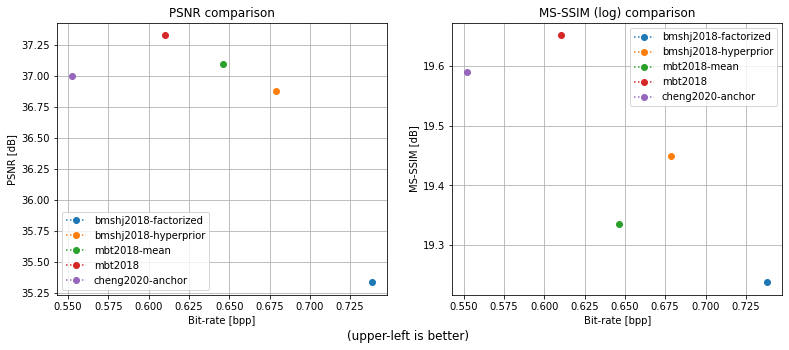

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')
for name, m in metrics.items():
    axes[0].plot(m['bit-rate'], m['psnr'], 'o', label=name, linestyle='dotted')
    axes[0].legend(loc='best')
    axes[0].grid()
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')
    axes[1].plot(m['bit-rate'], -10*np.log10(1-m['ms-ssim']), 'o', label=name, linestyle='dotted')
    axes[1].legend(loc='best')
    axes[1].grid()
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

plt.show()